In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump
import pickle
import os

In [31]:
os.getcwd()

'C:\\Users\\PC\\Desktop\\EMI\\S3\\ML\\F_projet'

In [32]:
# Load and preprocess data
data = pd.read_csv('salary Data.csv')
data.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor,Software Engineer,5.0,90000.0
1,28.0,Female,Master,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor,Sales Aociate,7.0,60000.0
4,52.0,Male,Master,Director,20.0,200000.0


### Statistique descriptive

In [40]:
data.describe()

,Age,Years of Experience,Salary
count,373.000000,373.000000,373.000000
mean,37.431635,10.030831,100577.345845
std,7.069073,6.557007,48240.013482
min,23.000000,0.000000,350.000000
25%,31.000000,4.000000,55000.000000
50%,36.000000,9.000000,95000.000000
75%,44.000000,15.000000,140000.000000
max,53.000000,25.000000,250000.000000


### Interprétation des statistiques descriptives
Âge : L'âge des individus varie de 23 à 53 ans, avec une moyenne de 37,43 ans. L'écart-type de 7,07 indique une certaine diversité, bien que la majorité des individus aient entre 31 et 44 ans.

Années d'expérience : L'expérience varie de 0 à 25 ans, avec une moyenne de 10,03 ans. La majorité des individus ont entre 4 et 15 ans d'expérience, ce qui montre un échantillon équilibré entre débutants et professionnels expérimentés.

Salaire : Les salaires vont de 350 à 250,000, avec une moyenne de 100,577. L'écart-type élevé (48,240) suggère une grande dispersion des salaires, la plupart des individus gagnant entre 55,000 et 140,000.



### Statistique bivarié 

C:\Users\PC\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


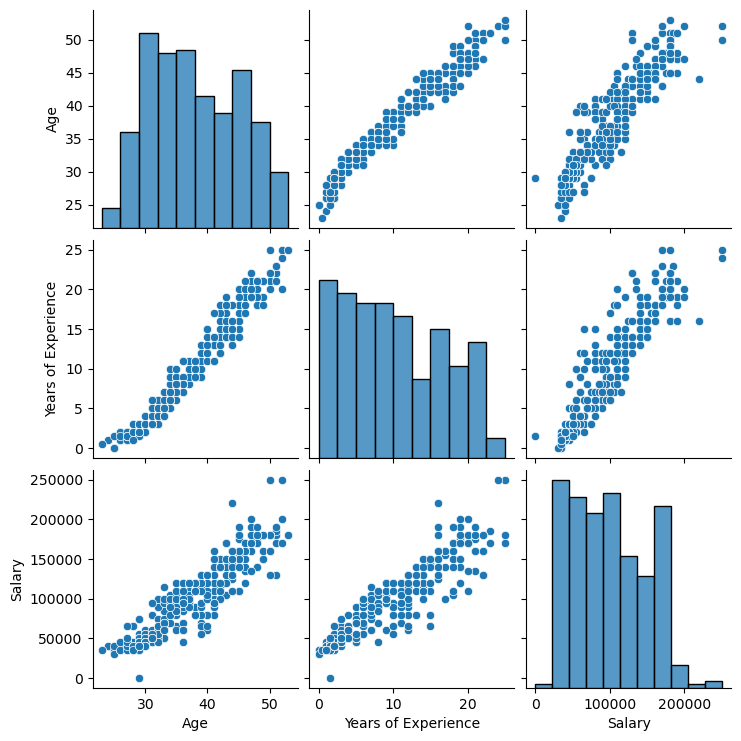

In [41]:
sns.pairplot(data[['Age', 'Years of Experience', 'Salary']])
plt.show()

Cette matrice de dispersion montre des corrélations positives entre l'Âge, les Années d'expérience et le Salaire : les personnes plus âgées et expérimentées tendent à avoir un salaire plus élevé. Les histogrammes sur la diagonale indiquent des distributions asymétriques pour le Salaire et les Années d'expérience, tandis que l'Âge est plus uniformément réparti. La standardisation des variables est recommandée pour éliminer les écarts d'échelle, ce qui permettrait une analyse statistique plus précise et cohérente des relations entre les variables.

In [33]:
data.dtypes 

Age                    float64
Gender                  object
Education Level         object
Job Title               object
Years of Experience    float64
Salary                 float64
dtype: object

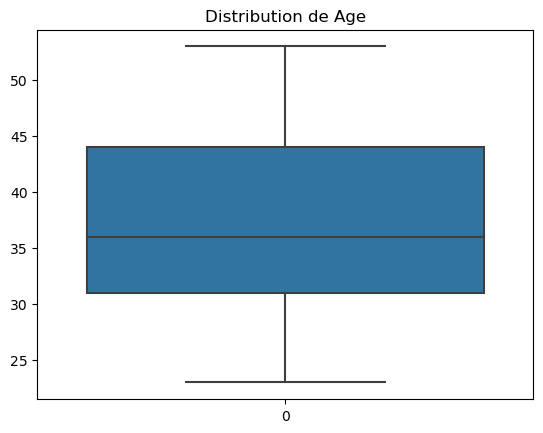

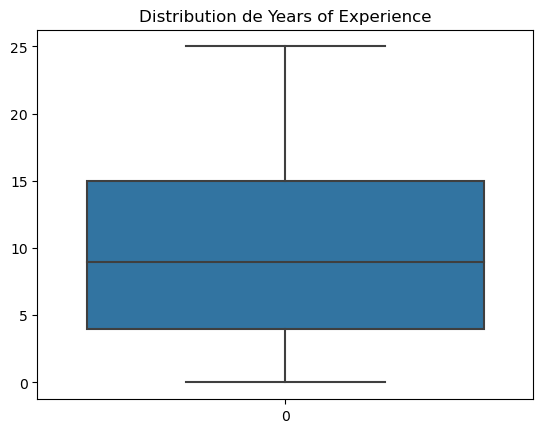

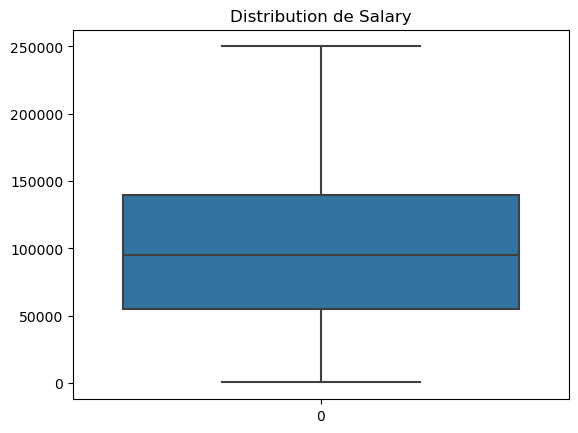

In [34]:
# Affichage des boxplots pour détecter les valeurs aberrantes
for column in ['Age', 'Years of Experience', 'Salary']:
    sns.boxplot(data[column])
    plt.title(f'Distribution de {column}')
    plt.show()

## Pas de valeurs aberante 

In [35]:
compte = data['Job Title'].value_counts()
compte

Job Title
Director of Marketing              12
Director of Operations             11
Senior Busine Analyst              10
Senior Marketing Analyst            9
Senior Marketing Manager            9
                                   ..
Busine Development Manager          1
Customer Service Representative     1
IT Manager                          1
Digital Marketing Manager           1
Junior Web Developer                1
Name: count, Length: 174, dtype: int64

### Cette variable catégorielle contient 174 modalité 
 Cette variable catégorielle comporte 174 modalités. Réaliser un encodage sur cette variable pourrait entraîner un accroissement significatif du nombre de variables, ce qui risquerait de poser des problèmes lors de l'entraînement de notre modèle.

Pour optimiser le modèle et éviter une complexité excessive, nous procéderons à une sélection des variables. Bien que la variable catégorielle avec ses 174 modalités soit utile our plus de précision, son encodage rendra le modèle trop complexe. Nous conserverons donc cette variable tout en sélectionnant les autres plus pertinentes.

In [36]:
#suppression des lignes contant des valeurs manquantes 
data = data.dropna(how='all')

# Define the education order for ordinal encoding
education_order = ["Bachelor", "Master", "PhD"]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'Years of Experience']),
        ('gender', OneHotEncoder(drop='first'), ['Gender']),
        ('educ', OrdinalEncoder(categories=[education_order]), ['Education Level'])
    ],
    remainder='drop'
)


Le code precedent supprime les lignes avec des valeurs manquantes et définit un ordre pour le codage ordinal de Education Level. Il crée ensuite un pipeline de prétraitement utilisant un ColumnTransformer : il standardise Age et Years of Experience, applique un OneHotEncoder à Gender, et un OrdinalEncoder à Education Level, tout en supprimant les autres colonnes.

In [37]:
# Separation des variables explicatives et la varible cible
X = data[['Age', 'Gender', 'Education Level', 'Years of Experience']]
y = data['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Élaboration des modèles et optimisation des hyperparamètre 

In [39]:

# Define models and hyperparameter grids
param_grids = {
    'LinearRegression': {
        'regressor': [LinearRegression()]
    },
    'Ridge': {
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 10.0],
        'regressor__max_iter': [1000, 5000]
    },
    'Lasso': {
        'regressor': [Lasso()],
        'regressor__alpha': [0.01, 0.1, 1.0],
        'regressor__max_iter': [1000, 5000],
        'regressor__tol': [0.001, 0.01]
    },
    'ElasticNet': {
        'regressor': [ElasticNet()],
        'regressor__alpha': [0.01, 0.1, 1.0],
        'regressor__l1_ratio': [0.2, 0.5, 0.8],
        'regressor__max_iter': [1000, 5000],
        'regressor__tol': [0.001, 0.01]
    }
}

# Initialize variables to store the best model and score
best_model = None
best_score = float('-inf')
best_name = ""

# Train and evaluate each model with GridSearchCV
for model_name, params in param_grids.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', params['regressor'][0])
    ])
    
    grid_search = GridSearchCV(pipeline, param_grid=params, scoring='r2', cv=5)
    grid_search.fit(X_train, y_train)
    
    # Evaluate the best model from the grid search
    best_pipeline = grid_search.best_estimator_
    y_pred = best_pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} Best Params: {grid_search.best_params_}")
    print(f"{model_name} Performance: R^2 = {r2}, MSE = {mean_squared_error(y_test, y_pred)}")
    
    # Select the best model based on R^2 score
    if r2 > best_score:
        best_score = r2
        best_model = best_pipeline
        best_name = model_name
#enregistrement du moèle 
if best_model:
    with open(f'best_{best_name}_model.pkl', 'wb') as file:
        pickle.dump(best_model, file)
    print(f"Best model saved as 'best_{best_name}_model.pkl'.")
    
    
# Function to predict salary with the best model
def predict_salary(age, gender, educ, exp, model_path=f'best_{best_name}_model.pkl'):
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
    
    new_data = pd.DataFrame([[age, gender, educ, exp]], columns=['Age', 'Gender', 'Education Level', 'Years of Experience'])
    predicted_salary = model.predict(new_data)
    return predicted_salary


# Example usage
age = 30
gender = 'Male'
educ = 'Master'
exp = 5
predicted_salary = predict_salary(age, gender, educ, exp)
print("Predicted Salary:", predicted_salary)


LinearRegression Best Params: {'regressor': LinearRegression()}
LinearRegression Performance: R^2 = 0.9029876738433329, MSE = 232595028.52964878
Ridge Best Params: {'regressor': Ridge(alpha=10.0, max_iter=1000), 'regressor__alpha': 10.0, 'regressor__max_iter': 1000}
Ridge Performance: R^2 = 0.9052414870162865, MSE = 227191326.13396522
Lasso Best Params: {'regressor': Lasso(tol=0.01), 'regressor__alpha': 1.0, 'regressor__max_iter': 1000, 'regressor__tol': 0.01}
Lasso Performance: R^2 = 0.9029207745213463, MSE = 232755425.15472254
ElasticNet Best Params: {'regressor': ElasticNet(alpha=0.1, l1_ratio=0.8, tol=0.01), 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.8, 'regressor__max_iter': 1000, 'regressor__tol': 0.01}
ElasticNet Performance: R^2 = 0.905124012144208, MSE = 227472981.79881823
Best model saved as 'best_Ridge_model.pkl'.
Predicted Salary: [74617.94818732]
